### Step 1 – Load Data

In [59]:
import os

print("Current working directory:", os.getcwd())

Current working directory: c:\Users\Babak.Baradaranhezav\ml-projects\ml_airbnb_price_regression


In [60]:
from pathlib import Path
import os

# Set working directory only if not already set
cwd = Path.cwd()
if not (cwd / ".git").exists():
    for parent in cwd.parents:
        if (parent / ".git").exists():
            os.chdir(parent)
            print("Working directory set to repo root:", parent)
            break
    else:
        raise FileNotFoundError("Could not find .git repo root. Are you inside the correct project folder?")
else:
    print("Already in repo root:", cwd)


Already in repo root: c:\Users\Babak.Baradaranhezav\ml-projects\ml_airbnb_price_regression


In [61]:
import pandas as pd

pd.set_option('future.no_silent_downcasting', True)

# Read the featured listings CSV using a path relative to the repo root
df = pd.read_csv("data/processed/featured_listings.csv")

print(f"Loaded data with shape: {df.shape}")
df.head()


Loaded data with shape: (5090, 86)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_log,host_age_days,days_since_last_review,room_type_Hotel room,room_type_Private room,room_type_Shared room,avg_review_score
0,13188,https://www.airbnb.com/rooms/13188,2.025060e+13,6/25/2025,city scrape,Garden level studio in ideal loc.,Garden level studio suite with garden patio - ...,The uber hip Main street area is a short walk ...,https://a0.muscache.com/pictures/8408188/e1af6...,51466,...,0,0,1.93,4.919981,5740,29.0,False,False,False,4.872857
1,16611,https://www.airbnb.com/rooms/16611,2.025060e+13,6/21/2025,previous scrape,"1 block to skytrain station, shops,restaurant,...","My place is close to bank, coffee shops, groce...",Next block to Commercial Drive which has many ...,https://a0.muscache.com/pictures/82101/7127b63...,58512,...,0,0,0.03,NaN,5715,2714.0,False,False,False,4.000000
2,18270,https://www.airbnb.com/rooms/18270,2.025060e+13,6/21/2025,city scrape,private rm in clean central 2BR apt,I have a bright furnished 2 bedroom suite on a...,"Lots of restaurants, coffee shops.<br />Easy a...",https://a0.muscache.com/pictures/108520241/aec...,70437,...,1,0,0.68,3.850148,5669,2031.0,False,True,False,4.525714
3,18589,https://www.airbnb.com/rooms/18589,2.025060e+13,6/25/2025,city scrape,Commercial Drive B&B,"As hosts, we are welcoming you into our home, ...",Lots of restaurants and boutiques just outside...,https://a0.muscache.com/pictures/dd3ca406-cb74...,71508,...,1,0,3.54,5.236442,5665,29.0,False,True,False,4.971429
4,18795,https://www.airbnb.com/rooms/18795,2.025060e+13,6/21/2025,city scrape,*Best choice in downtown-5 Stars * -2,NaN,NaN,https://a0.muscache.com/pictures/96249/03d3af8...,70137,...,4,0,0.76,4.330733,5670,783.0,False,True,False,4.612857


### Step 2 – Define Target + Features

In [62]:
# Drop rows where price is missing
df = df.dropna(subset=['price'])

# Drop 'price_log' if exists (to avoid data leakage)
if 'price_log' in df.columns:
    df = df.drop(columns=['price_log'])
    print("Dropped 'price_log' to avoid data leakage.")

# Drop unnecessary or ID columns
drop_cols = ['id', 'name', 'host_id', 'host_name', 'last_review', 'license']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Separate target and features
target = 'price'
y = df[target]
X = df.drop(columns=[target])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Ensure index alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Print confirmation
print("Features and target prepared.")
print("X shape:", X.shape)
print("Remaining dtypes:\n", X.dtypes.value_counts())


Dropped 'price_log' to avoid data leakage.
Features and target prepared.
X shape: (4238, 32414)
Remaining dtypes:
 bool       32369
int64         24
float64       21
Name: count, dtype: int64


### Step 3 – Train/Test Split

In [63]:
from sklearn.model_selection import train_test_split

# STEP 3: Train-test split (using already cleaned and encoded X, y from Step 2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Training rows: {X_train.shape[0]} | Test rows: {X_test.shape[0]}")


Training rows: 3390 | Test rows: 848


### Step 4 – Baseline Model

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Predict the mean of y_train
mean_price = y_train.mean()
y_pred_baseline = pd.Series([mean_price] * len(y_test), index=y_test.index)

# Check for missing values in y_test or predictions
print("Missing values in y_test:", y_test.isnull().sum())
print("Missing values in y_pred_baseline:", y_pred_baseline.isnull().sum())

# Apply mask safely
mask = ~y_test.isnull()
mae = mean_absolute_error(y_test[mask], y_pred_baseline[mask])
rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred_baseline[mask]))

# Show metrics
print(f"Baseline Mean Prediction: {mean_price:.2f}")
print(f"Baseline MAE: {mae:.2f}")
print(f"Baseline RMSE: {rmse:.2f}")


Missing values in y_test: 0
Missing values in y_pred_baseline: 0
Baseline Mean Prediction: 257.05
Baseline MAE: 126.85
Baseline RMSE: 187.42


In [65]:
# Check for data leakage before model training because of potential leakage columns (price, price_log, etc.)
print("Potential leakage columns:", [col for col in X_train.columns if 'price' in col.lower()])

Potential leakage columns: ['description_*****Minimum 90 Days Rental*****<br /><br />Stunning, unobstructed VIEW of marina & North Shore mountains. This immaculate home features a fully furnished  1 bedroom, 1  full bathroom, and 1 secured parking. Enjoy beautiful views from your living room - watching boats sail by. Steps to excellent amenities, shops, restaurants, Vancouver Convention Centre, parks, & seawall. Enjoy the vibrant Coal Harbour at an affordable price. Steps to shopping, transit, fine dining, & a short distance to Stanley Park.', 'description_5-minute walk to restaurants, banks, supermarkets, and bus stops.<br />The room is l bright and cozy, stylishly furnished with a queen-size bed, desk & chair, shelf, and a built-in closet.<br />This is a quiet & nice neighborhood, with free parking in front, Bus 10,17 & 16 direct to Vancouver downtown (30 minutes), and 8 minutes to the Airport. PS: This price is for one person.', 'description_800-square-foot home on two levels with a

### Step 5 – Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. One-hot encode train and test
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# 2. Drop duplicate columns (edge case protection)
X_train_encoded = X_train_encoded.T.drop_duplicates().T
X_test_encoded = X_test_encoded.T.drop_duplicates().T

# 3. Align test columns to match training columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 4. Fill missing values and handle types
X_train_encoded = X_train_encoded.fillna(0).infer_objects(copy=False)
X_test_encoded = X_test_encoded.fillna(0).infer_objects(copy=False)

# 5. Train model
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# 6. Predict
y_pred_lr = lr_model.predict(X_test_encoded)

# 7. Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression MAE: {mae_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")


Linear Regression MAE: 77.04
Linear Regression RMSE: 119.23


### Step 6 – Ridge & Random Forest Regression

In [67]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Set seed for reproducibility
SEED = 42

# Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=SEED)
ridge_model.fit(X_train_encoded, y_train)
y_pred_ridge = ridge_model.predict(X_test_encoded)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print("Ridge Regression")
print(f"MAE: {mae_ridge:.2f}")
print(f"RMSE: {rmse_ridge:.2f}")

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=SEED)
rf_model.fit(X_train_encoded, y_train)
y_pred_rf = rf_model.predict(X_test_encoded)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\nRandom Forest Regressor")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")


Ridge Regression
MAE: 73.82
RMSE: 115.89

Random Forest Regressor
MAE: 40.16
RMSE: 95.76


### Step 7 – Model Comparison (Compare All Models)

Model Performance Comparison:
               Model         MAE        RMSE
0      Random Forest   40.161026   95.755234
1   Ridge Regression   73.821275  115.891443
2  Linear Regression   77.040617  119.227439
3    Baseline (Mean)  126.845122  187.421806


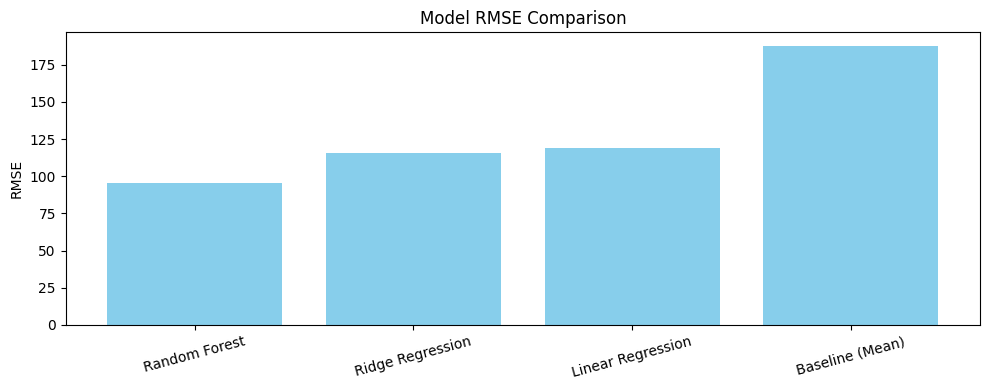

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison table
results = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'Linear Regression', 'Ridge Regression', 'Random Forest'],
    'MAE': [mae, mae_lr, mae_ridge, mae_rf],
    'RMSE': [rmse, rmse_lr, rmse_ridge, rmse_rf]
})

# Sort by RMSE (lower is better)
results = results.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("Model Performance Comparison:")
print(results)

# Optional: Bar chart visualization
plt.figure(figsize=(10, 4))
plt.bar(results['Model'], results['RMSE'], color='skyblue')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [69]:
#checking the available column names
from src.preprocessing import build_preprocessing_pipeline
import joblib

df_raw = pd.read_csv("data/processed/featured_listings.csv")
print(df_raw.columns.tolist())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

### STEP 8: Fit and save preprocessing pipeline before one-hot encoding or model training

In [70]:
from src.preprocessing import build_preprocessing_pipeline
import joblib
import pandas as pd

# Load the featured dataset
df_raw = pd.read_csv("data/processed/featured_listings.csv")

# Define feature columns (should match training features)
numerical_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'review_scores_rating'
]

categorical_features = [
    'host_is_superhost', 'instant_bookable', 'neighbourhood_cleansed', 'room_type'
]

all_features = numerical_features + categorical_features

# Subset just the features used in modeling
X_raw = df_raw[all_features].copy()

# Build and fit preprocessing pipeline
pipeline, _, _ = build_preprocessing_pipeline()
pipeline.fit(X_raw)

# Save fitted pipeline for later use in prediction
joblib.dump(pipeline, "models/fitted_pipeline.joblib")
print("Fitted pipeline saved to models/fitted_pipeline.joblib")






Fitted pipeline saved to models/fitted_pipeline.joblib


### Step 8: Save the Best Model + Prepare for Deployment (pickle, joblib, etc.)

- pip install joblib (First through terminal)
- Then Save model + columns as below

In [71]:
import joblib
#from pathlib import Path

# Step 1: Define path to models folder relative to current working directory
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)  # create folder if it doesn't exist

# Step 2: Save Random Forest model
model_path = models_dir / "random_forest_model.joblib"
joblib.dump(rf_model, model_path)

# Step 3: Save training column names
columns_path = models_dir / "model_columns.joblib"
joblib.dump(X_train_encoded.columns.tolist(), columns_path)

print(f"Model saved to: {model_path}")
print(f"Feature columns saved to: {columns_path}")


Model saved to: models\random_forest_model.joblib
Feature columns saved to: models\model_columns.joblib


### Step 9 - Created a train_model.py at route of the project. Now I need to run that file to train the model.
#### run the file using this code: python train_model.py in ml_airbnb_price_regression directory.

### Step 10 - Created predict.py in src folder for predicting the price

### Step 11 - Prediction on the data
##### Now that we have our model, we can use it to make predictions on the data.
##### On terminal or VSCODE pwsh , run the following command: python src/predict.py sample_listing.json

### Step 9 – Build a predict_price() Function

I need a reusable function that takes new input data, processes it exactly like my training data, and returns a predicted price. This is what I do in a real deployment scenario like a Flask API, Streamlit app, or batch prediction job.

What This Function Should Do:
Accept: a new listing (as a dictionary or DataFrame row)

Preprocess:

- One-hot encode categorical variables

- Align with training columns

- Fill missing values

Load:

- Trained model (random_forest_model.pkl)

- Model columns (model_columns.pkl)

- Predict: using the model

- Return: the predicted price

### Step 9 – Initial Version of `predict_price()`
This was the first working version of the `predict_price()` function. It loads a saved Random Forest model and column list, prepares input data, and returns a nightly price prediction. In upcoming cells I will refine this function to improve performance and accuracy. SO if I want to see the first version in action, I need to change the below cell to Code.

import joblib
import pandas as pd
import numpy as np
from pathlib import Path

def predict_price(input_data):
    """
    Predicts the Airbnb listing price for a new sample based on a trained Random Forest model.

    Parameters:
    - input_data (dict or pd.Series): New listing information.

    Returns:
    - float: Predicted price in CAD
    """
    # Load trained model and training columns
    model = joblib.load("models/random_forest_model.joblib")
    model_columns = joblib.load("models/model_columns.joblib")

    # Convert input to DataFrame
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = pd.DataFrame([input_data.to_dict()])

    print("Input listing features:")
    display(input_df)

    # One-hot encode categorical variables
    input_encoded = pd.get_dummies(input_df)

    # Align input with model columns (add missing columns as 0)
    input_aligned = input_encoded.reindex(columns=model_columns, fill_value=0)

    # Predict using the trained model
    predicted_price = model.predict(input_aligned)[0]
    predicted_price = float(predicted_price)

    # Output the result with explanation
    print("\nHow this works:")
    print("- The input listing is first converted to a structured DataFrame.")
    print("- Categorical features like 'room_type' and 'neighbourhood' are one-hot encoded.")
    print("- We match the structure of training features exactly to avoid mismatches.")
    print("- The trained Random Forest model then predicts the price based on these inputs.\n")

    print(f"Predicted price for this listing: **${predicted_price:.2f} CAD**")
    print(f"This is the estimated price per night (in CAD) for the listing described above.")


    return predicted_price


sample_input = {
    'host_is_superhost': True,
    'room_type': 'Entire home/apt',
    'accommodates': 4,
    'bathrooms': 1.0,
    'bedrooms': 2,
    'beds': 2,
    'price': 150,
    'minimum_nights': 2,
    'maximum_nights': 1125,
    'number_of_reviews': 24,
    'instant_bookable': False,
    'review_scores_rating': 95.0,
    'neighbourhood_cleansed': 'Downtown'
}

predict_price(sample_input)


### Step 9 – Enhanced predict_price() Function for Production Readiness
This version is built for real-world deployment scenarios such as APIs, Streamlit apps, or batch pipelines. It improves the original function by adding:

Input Flexibility: Accepts input as a dict, Series, or DataFrame.

Field Validation: Ensures all required fields are present.

Type Checking: Verifies numerical fields are valid numbers.

Smart Preprocessing: Uses a scikit-learn pipeline with:

- SimpleImputer to fill missing numerical values using training-time strategies.

- OneHotEncoder for robust categorical handling (supports unseen categories).

Training Consistency: Aligns features with the original model's structure.

Logging: Adds runtime logs to trace behavior and debugging.

Error Handling: Raises meaningful exceptions on invalid input.

This mirrors what a backend function would look like when serving predictions in production or embedded into a larger system.


#### This code was for creating predct.py in the notebook instead.
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)

# Load trained model and model columns
model = joblib.load("models/random_forest_model.joblib")
model_columns = joblib.load("models/model_columns.joblib")

# Define preprocessing pipeline
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
                      'maximum_nights', 'number_of_reviews', 'review_scores_rating']
categorical_features = ['host_is_superhost', 'room_type', 'instant_bookable', 'neighbourhood_cleansed']

numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

def predict_price_advanced(input_data):
    """
    Enhanced price prediction with:
    - Input validation
    - Type checking
    - Scikit-learn preprocessing pipeline
    - Error handling and logging
    - Explanation of each step for clarity
    """
    # Convert to DataFrame
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    elif isinstance(input_data, pd.Series):
        input_df = pd.DataFrame([input_data.to_dict()])
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data.copy()
    else:
        raise ValueError("Input must be a dict, pd.Series, or pd.DataFrame")

    # Validate required fields
    required_fields = numerical_features + categorical_features
    missing_fields = [f for f in required_fields if f not in input_df.columns]
    if missing_fields:
        raise ValueError(f"Missing required fields: {missing_fields}")

    # Type checking
    for field in numerical_features:
        if not np.issubdtype(input_df[field].dtype, np.number):
            raise TypeError(f"Field '{field}' must be numeric")

    # Preprocess
    logging.info("Preprocessing input...")
    processed_input = pipeline.fit_transform(input_df)

    # Align with training columns
    encoded_df = pd.DataFrame(
        processed_input.toarray() if hasattr(processed_input, 'toarray') else processed_input
    )
    encoded_df = encoded_df.reindex(columns=model_columns, fill_value=0)

    # Predict
    prediction = model.predict(encoded_df)[0]
    prediction = round(float(prediction), 2)

    # Explanation
    print("\nHow this works:")
    print("- The input listing is validated and converted to a DataFrame.")
    print("- Numerical features are imputed (missing values filled with mean).")
    print("- Categorical variables are one-hot encoded using scikit-learn.")
    print("- The resulting input is aligned with the original training columns.")
    print("- Finally, the trained Random Forest model predicts the price.\n")
    print(f"Predicted price for this listing: ${prediction:.2f} CAD")
    print("This is the estimated price per night (in CAD) for the listing provided above.")

    return prediction


sample_input = {
    'host_is_superhost': True,
    'room_type': 'Entire home/apt',
    'accommodates': 4,
    'bathrooms': 2.0,
    'bedrooms': 4,
    'beds': 5,
    'price': 260,
    'minimum_nights': 2,
    'maximum_nights': 1000,
    'number_of_reviews': 12,
    'instant_bookable': False,
    'review_scores_rating': 90.0,
    'neighbourhood_cleansed': 'Downtown'
}

predict_price_advanced(sample_input)



In [56]:
import os
print("Notebook Path:", Path().resolve())
print("src exists:", (Path().resolve().parents[0] / "src").exists())
print("predict.py exists:", (Path().resolve().parents[0] / "src" / "predict.py").exists())


Notebook Path: C:\Users\Babak.Baradaranhezav\ml-projects\ml_airbnb_price_regression
src exists: False
predict.py exists: False


In [57]:
import inspect
import src.predict

print(dir(src.predict))  # Lists everything defined in the module


['Path', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'build_preprocessing_pipeline', 'categorical_features', 'datetime', 'joblib', 'log_dir', 'logging', 'model', 'model_columns', 'np', 'numerical_features', 'pd', 'pipeline', 'predict_price_advanced_module', 'project_root', 'sys', 'uuid']


In [74]:
import sys
import importlib
from pathlib import Path

# Ensure src is in path
project_root = Path().resolve()
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Force reload
import src.predict
importlib.reload(src.predict)

from src.predict import predict_price_advanced_module



sample_input = {
    'host_is_superhost': True,
    'room_type': 'Entire home/apt',
    'accommodates': 4,
    'bathrooms': 1.0,
    'bedrooms': 2,
    'beds': 2,
    'price': 150,
    'minimum_nights': 2,
    'maximum_nights': 1125,
    'number_of_reviews': 24,
    'instant_bookable': False,
    'review_scores_rating': 95.0,
    'neighbourhood_cleansed': 'Downtown'
}

predict_price_advanced_module(sample_input)


INFO:root:Request ID: 26d3b1d2-ab1e-40e3-8db0-2b1519ef4994
Timestamp : 2025-07-23T22:58:11.564943
Input     : host_is_superhost=True, room_type=Entire home/apt, accommodates=4, bathrooms=1.0, bedrooms=2, beds=2, price=150, minimum_nights=2, maximum_nights=1125, number_of_reviews=24, instant_bookable=False, review_scores_rating=95.0, neighbourhood_cleansed=Downtown
Prediction: $411.85 CAD





How this works:
- Input is validated and converted to DataFrame.
- Numerical fields are imputed using means.
- Categorical fields are one-hot encoded.
- Result is aligned with model training features.
- Prediction is made using the trained model.

Predicted price for this listing: $411.85 CAD
This is the estimated price per night (in CAD) for the listing described above.


411.85